# This is my coursera data science capstone project.

## Despite the distinct culture and geographcial location differences of New York, Toronto, Beijing and Shanghai, I'm tring to search for similar neighborhoods among these cities.

## Let's start with importing necessary libraries.


In [1]:
# import necessary packages
import numpy as np
import pandas as pd 
import json
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium # map rendering library
from bs4 import BeautifulSoup

print('Libraries imported.')


Libraries imported.


In [2]:
# obtain New York neighborhood data
with open('new_york.json') as json_data:
    newyork_data = json.load(json_data)
    
nyneighborhoods = newyork_data['features']

# define the dataframe with four columns: City, Borough, Neighborhood, Latitude, Longitude
column_names = ['City','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyneighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'City': 'New York',
                                          'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


In [3]:
#Define a function to plot the city map with different neighborhood labels based on Borough
def citymap(cityname,countryname,dataframe):
    # create map
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Borough
    borough_name = dataframe['Borough'].unique().tolist()
    colnum = dataframe['Borough'].unique().size
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map

    for lat, lon, neighborhood, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Neighborhood'], dataframe['Borough']):
        cluster = borough_name.index(borough)
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
       
    
    return my_map

In [4]:
citymap('New York','USA',ny_neighborhoods)

## We see that all the neighorhoods in the same Borough fall into the same color and are well seprated in map, indicating good quality of data.
# Now Let's look at neighborhoods in Toronto:

In [5]:
# obtain Toronto neighborhood data
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wikipage = requests.get(url)
wikipage.text[:100]

#Create a new pd DataFrame
toronto = pd.DataFrame()

#use beautifulsoup to read the wikipage
soup = BeautifulSoup(wikipage.text, 'lxml')
wikitable = soup.find_all('table')[0] 

row_marker = 0

for row in wikitable.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        toronto.loc[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

#rename column names
toronto.rename(columns={0:'PostalCode',1:'Borough',2:'Neighborhood'}, inplace=True)
#drop all rows with unassigned borough
toronto = toronto[toronto.Borough!='Not assigned']
toronto.reset_index(drop=True,inplace=True)

#create a new dataframe toronto_neighbor to find all neighborhoods with the location information
toronto_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for ii in range(toronto.shape[0]):
    borough = toronto.loc[ii,'Borough']
    postalcode = toronto.loc[ii,'PostalCode']
    neighborhood = toronto.loc[ii,'Neighborhood'][:-1] #delete the last character \n
    
    #if the neighborhood name is not assigned, than the neighorhood name is same as borough
    if neighborhood == 'Not assigned':
        neighborhood = borough
    
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="mycapstoneproject")
    location = geolocator.geocode("{},{},Toronto,Ontario,Canada".format(neighborhood,borough))
    
    #try one more searching
    if location is None: 
        location = geolocator.geocode("{},Toronto,Ontario,Canada".format(neighborhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        toronto_neighborhoods = toronto_neighborhoods.append({'City': 'Toronto',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

toronto_neighborhoods.head()

The location data of Humewood-Cedarvale in York is not available!
The location data of Caledonia-Fairbanks in York is not available!
The location data of CFB Toronto in North York is not available!
The location data of Del Ray in York is not available!
The location data of North Midtown in Central Toronto is not available!
The location data of Canada Post Gateway Processing Centre in Mississauga is not available!
The location data of Island airport in Downtown Toronto is not available!
The location data of Railway Lands in Downtown Toronto is not available!
The location data of Humber Bay Shores in Etobicoke is not available!
The location data of Beaumond Heights in Etobicoke is not available!
The location data of Stn A PO Boxes 25 The Esplanade in Downtown Toronto is not available!
The location data of Business reply mail Processing Centre969 Eastern in East Toronto is not available!


,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.761124,-79.324059
1,Toronto,North York,Victoria Village,43.732658,-79.311189
2,Toronto,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,Toronto,Downtown Toronto,Regent Park,43.660706,-79.360457
4,Toronto,North York,Lawrence Heights,43.722778,-79.450933


In [6]:
citymap('Toronto','Canada',toronto_neighborhoods)

## By looking at the map carefully, there are three outliers jump into downtown area: Queen's Park, Trinity and Studio District, which is caused by the mismatch in geocoder. Let's clean it:

In [7]:
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Queen\'s Park']
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Trinity']
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Studio District']
toronto_neighborhoods.reset_index(drop=True,inplace=True)
toronto_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.761124,-79.324059
1,Toronto,North York,Victoria Village,43.732658,-79.311189
2,Toronto,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,Toronto,Downtown Toronto,Regent Park,43.660706,-79.360457
4,Toronto,North York,Lawrence Heights,43.722778,-79.450933


# Let's plot the map of Toronto again

In [213]:
citymap('Toronto','Canada',toronto_neighborhoods)

# It looks clean now. Let's look at Beijing and Shanghai.

In [9]:
# read the csv file extracted from Wikipedia including the Districts and Subdisctricts
bj = pd.read_csv('Beijing.csv')
bj.rename(columns={'District':'Borough','Subdisctricts':'Neighborhood'}, inplace=True)
bj.head()

,City,Borough,Neighborhood
0,Beijing,Changping,Chengbei
1,Beijing,Changping,Chengnan
2,Beijing,Changping,Huilongguan
3,Beijing,Changping,Longzeyuan
4,Beijing,Changping,Shigezhuang


In [10]:
#create a new dataframe bj_neighbor to find all neighborhoods with the location information
bj_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for ii in range(bj.shape[0]):
    borough = bj.loc[ii,'Borough']
    neighborhood = bj.loc[ii,'Neighborhood']
      
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode("{},{},Beijing,China".format(neighborhood,borough))
    
    #try one more searching
    if location is None: 
        location = geolocator.geocode("{},Beijing,China".format(neighborhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        bj_neighborhoods = bj_neighborhoods.append({'City': 'Beijing',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

bj_neighborhoods.head()

The location data of Chengbei in Changping is not available!
The location data of Longzeyuan in Changping is not available!
The location data of Tiantongyuanbei in Changping is not available!
The location data of Machikou in Changping is not available!
The location data of Dongxiaokou in Changping is not available!
The location data of Xiaotangshan in Changping is not available!
The location data of Cuicun in Changping is not available!
The location data of Baishan in Changping is not available!
The location data of Beiqijia in Changping is not available!
The location data of Xingshou in Changping is not available!
The location data of Shasanling in Changping is not available!
The location data of Yanshou in Changping is not available!
The location data of Heping Aveue in Chaoyang is not available!
The location data of Aoyuncun in Chaoyang is not available!
The location data of Guanyinsi in Daxing is not available!
The location data of Beizangcun in Daxing is not available!
The locatio

,City,Borough,Neighborhood,Latitude,Longitude
0,Beijing,Changping,Chengnan,40.299030,116.637321
1,Beijing,Changping,Huilongguan,40.069525,116.329755
2,Beijing,Changping,Shigezhuang,39.931943,116.557680
3,Beijing,Changping,Tiantongyuannan,40.065123,116.406506
4,Beijing,Changping,Huoying,40.069357,116.354448


In [12]:
bj_neighborhoods.shape

(211, 5)

## A number of neighborhoods don't have location data. But anyway, there are more than 200 neighborhoods with valid location data, enough for my analysis. Show these neighborhoods on map:

In [13]:
citymap('Beijing','China',bj_neighborhoods)

## Some nerghborhoods doesn't lie into their boroughs (wrong location data). Let's clean it out.

In [14]:
drop = ['Xiangyang','Shilipu','Jiuxian','Binhe','Xincun','Yongding','Shiyuan','Dayu','Shuguang','Guangning','Beiwu',
       'Dongfeng','Guangming','Liucun','Nankou']

for neighborhoods in drop:
    bj_neighborhoods = bj_neighborhoods[bj_neighborhoods.Neighborhood != neighborhoods]
    bj_neighborhoods.reset_index(drop=True,inplace=True)
    
bj_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Beijing,Changping,Chengnan,40.299030,116.637321
1,Beijing,Changping,Huilongguan,40.069525,116.329755
2,Beijing,Changping,Shigezhuang,39.931943,116.557680
3,Beijing,Changping,Tiantongyuannan,40.065123,116.406506
4,Beijing,Changping,Huoying,40.069357,116.354448


In [15]:
citymap('Beijing','China',bj_neighborhoods)

## repeat the same process for Shanghai

In [16]:
# read the csv file extracted from Wikipedia including the Districts and Subdisctricts
sh = pd.read_csv('Shanghai.csv')
sh.rename(columns={'District':'Borough','Subdistrict':'Neighborhood'}, inplace=True)
sh.head()

,City,Borough,Neighborhood
0,Shanghai,Baoshan,Wusong
1,Shanghai,Baoshan,Youyi
2,Shanghai,Baoshan,Zhangmiao
3,Shanghai,Baoshan,Dachang
4,Shanghai,Baoshan,Gaojing


In [17]:
#create a new dataframe sh_neighbor to find all neighborhoods with the location information
sh_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for borough, neighborhood in zip(sh['Borough'],sh['Neighborhood']):   
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode("{},{},Shanghai,China".format(neighborhood,borough))
    
    #try one more searching
    if location is None: 
        location = geolocator.geocode("{},Shanghai,China".format(neighborhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        sh_neighborhoods = sh_neighborhoods.append({'City': 'Shanghai',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

sh_neighborhoods.head()

The location data of Miaohang in Baoshan is not available!
The location data of Xianhua in Changning is not available!
The location data of Zhoujiaqiao in Changning is not available!
The location data of Xidu in Fengxian is not available!
The location data of Shanghai Fengxian Bay Tourism Zone in Fengxian is not available!
The location data of Shanghai Seaport Comprehensive Economic Development Zone in Fengxian is not available!
The location data of Jiangwanzhen in Hongkou is not available!
The location data of Ruijin Second Road in Huangpu is not available!
The location data of Xiaodongmen in Huangpu is not available!
The location data of Jiadingzhen in Jiading is not available!
The location data of Juyuan New Area Administrative Committee in Jiading is not available!
The location data of Zhenxin in Jiading is not available!
The location data of Waigang in Jiading is not available!
The location data of Xuhang in Jiading is not available!
The location data of Jingansi in Jingan is not 

,City,Borough,Neighborhood,Latitude,Longitude
0,Shanghai,Baoshan,Wusong,31.374707,121.489410
1,Shanghai,Baoshan,Youyi,31.405927,121.471382
2,Shanghai,Baoshan,Zhangmiao,31.335766,121.440917
3,Shanghai,Baoshan,Dachang,31.294144,121.412396
4,Shanghai,Baoshan,Gaojing,31.323159,121.477525


In [215]:
citymap('Shanghai','China',sh_neighborhoods)

In [19]:
drop = ['Chenjia','Xinhe','Xincun','Zhongxing','Changzheng','Beizhan','Chaoyang Farm']

for neighborhoods in drop:
    sh_neighborhoods = sh_neighborhoods[sh_neighborhoods.Neighborhood != neighborhoods]
    sh_neighborhoods.reset_index(drop=True,inplace=True)
    
citymap('Shanghai','China',sh_neighborhoods)

In [20]:
# save the data
ny_neighborhoods.to_csv('ny_neighborhoods.csv', sep='\t')
toronto_neighborhoods.to_csv('toronto_neighborhoods.csv', sep='\t')
bj_neighborhoods.to_csv('bj_neighborhoods.csv', sep='\t')
sh_neighborhoods.to_csv('sh_neighborhoods.csv', sep='\t')

In [21]:
#Use Foursquare to expore the neighborhoods
#My Foursquare Credentials 
CLIENT_ID = 'S1KVEF2AKPAYLU1ETMETRFO3R0FWOUJXWWGQ55TILVFOAOLY' 
CLIENT_SECRET = 'G1EAHHBTQRSOP4JVOIQBM4QV452XF5JZBLV04MV0CSPKJLAF' 
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # only return the top 100 venues

# define a function to expore each city in radius of 1000 meters
def getNearbyVenues(nborhood, radius=1000):
    
    venues=pd.DataFrame(columns=['City','Borough','Neighborhood','VenueName','VenueCategory'])
    for city, borough, neighborhood, lat, lng in zip(nborhood['City'], nborhood['Borough'], nborhood['Neighborhood'], nborhood['Latitude'], nborhood['Longitude']):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        if results is not None:
            for v in results:
                venues = venues.append({'City':city, 'Borough':borough, 'Neighborhood': neighborhood, 
                           'VenueName': v['venue']['name'], 
                           'VenueCategory': v['venue']['categories'][0]['name']},ignore_index=True)

   
    
    return(venues)

In [22]:
# obtain the nearby venues of each neighborhood in New York
ny_venues = getNearbyVenues(ny_neighborhoods)
ny_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Rite Aid,Pharmacy
3,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant
4,New York,Bronx,Wakefield,Jackie's West Indian Bakery,Caribbean Restaurant


In [23]:
#save the data
ny_venues.to_csv('ny_venues.csv', sep='\t')
ny_venues.shape

(13257, 5)

In [24]:
#  to avoid multi-index problem
ny_venues = ny_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})

## Now we have total of 13257 venues available in New York. Let's repeat the process for Toronto, Beijing and Shanghai.

## Toronto

In [25]:
# repeat on Toronto
toronto_venues = getNearbyVenues(toronto_neighborhoods)
toronto_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,Toronto,North York,Parkwoods,Allwyn's Bakery,Caribbean Restaurant
1,Toronto,North York,Parkwoods,Tim Hortons,Café
2,Toronto,North York,Parkwoods,A&W Canada,Fast Food Restaurant
3,Toronto,North York,Parkwoods,LCBO,Liquor Store
4,Toronto,North York,Parkwoods,Food Basics,Supermarket


In [26]:
#save the data
toronto_venues.to_csv('toronto_venues.csv', sep='\t')

#  to avoid multi-index problem
toronto_venues = toronto_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
toronto_venues.shape

(6743, 5)

## Beijing

In [27]:
# repeat on Beijing
bj_venues = getNearbyVenues(bj_neighborhoods)
bj_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,Beijing,Changping,Chengnan,Longhu Garden,Lake
1,Beijing,Changping,Chengnan,小城故事 Story of Small Town,Korean Restaurant
2,Beijing,Changping,Huilongguan,大鸭梨烤鸭店（回龙观店）,Chinese Restaurant
3,Beijing,Changping,Huilongguan,BHG Mall (华联商厦),Shopping Mall
4,Beijing,Changping,Huilongguan,McDonald's (麦当劳),Fast Food Restaurant


In [28]:
#save the data
bj_venues.to_csv('bj_venues.csv', sep='\t')

#  to avoid multi-index problem
bj_venues = bj_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
bj_venues.shape

(2444, 5)

## Shanghai

In [29]:
# repeat on Beijing
sh_venues = getNearbyVenues(sh_neighborhoods)
sh_venues.head()


,City,Borough,Neighborhood,VenueName,VenueCategory
0,Shanghai,Baoshan,Wusong,Songbin Road Metro Station (淞滨路地铁站),Metro Station
1,Shanghai,Baoshan,Wusong,吴淞码头,General Travel
2,Shanghai,Baoshan,Wusong,Bund 1919 Art Area,Plaza
3,Shanghai,Baoshan,Wusong,新长江大酒店,Hotel
4,Shanghai,Baoshan,Youyi,McDonald's (麦当劳),Fast Food Restaurant


In [30]:
#save the data
sh_venues.to_csv('sh_venues.csv', sep='\t')

#  to avoid multi-index problem
sh_venues = sh_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
sh_venues.shape

(2303, 5)

## Now let's combine all the data into single dataframe and use machine learning model for clustering

In [31]:
#combine venues 
allvenues =  pd.concat([ny_venues,toronto_venues,bj_venues,sh_venues])
allvenues = allvenues.rename(columns={'Neighborhood': 'NeighborhoodName'})
allvenues.shape

(24747, 5)

In [32]:
allvenues.head()

,City,Borough,NeighborhoodName,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Rite Aid,Pharmacy
3,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant
4,New York,Bronx,Wakefield,Jackie's West Indian Bakery,Caribbean Restaurant


In [33]:
#combine neighborhoods
allneighborhoods =  pd.concat([ny_neighborhoods,toronto_neighborhoods,bj_neighborhoods,sh_neighborhoods])
allneighborhoods = allneighborhoods.rename(columns={'Neighborhood': 'NeighborhoodName'})
allneighborhoods.shape

(889, 5)

In [34]:
allneighborhoods.head()

,City,Borough,NeighborhoodName,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


## Group the venues depends on their categories and calculate the total number of venues of each category

In [37]:
# get dummies
allvenues_onehot = pd.get_dummies(allvenues, columns = ['VenueCategory'], prefix="", prefix_sep="")
allvenues_onehot = allvenues_onehot.drop('VenueName',axis = 1)
#allvenues_onehot.columns.values

## We need to clean the colums. For example, 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', and 'Arts & Entertainment' are basically in the same category. And 'Yunnan Resaurant', 'Zhejiang Resaurant','Hainan Resaurant' are all in the category of 'Chinese Resaurent'.

In [38]:
def clean_columns(columns,newcolumnname,dataframe):
    value = 0
    for column in columns:
        value = dataframe[column] + 0
    
    dataframe = dataframe.drop(columns,axis = 1)
    dataframe[newcolumnname] = value
    
    return dataframe

columns = ['Art Gallery', 'Art Museum', 'Arts & Crafts Store','Arts & Entertainment','Museum','Street Art','Public Art']
newcolumnname = 'Art Museum'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Auto Dealership', 'Auto Garage', 'Auto Workshop','Automotive Shop']
newcolumnname = 'Auto Shop'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Baseball Field','Baseball Stadium']
newcolumnname = 'Baseball Field'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Basketball Court', 'Basketball Stadium']
newcolumnname = 'Basketball Stadium'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Tennis Court', 'Tennis Stadium']
newcolumnname = 'Tennis Court'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Soccer Field', 'Soccer Stadium','Stadium']
newcolumnname = 'Stadium'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Bar','Beer Bar','Beer Garden', 'Beer Store','Cocktail Bar','Whisky Bar', 'Wine Bar','Sake Bar','Hotel Bar']
newcolumnname = 'Bar'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Wine Shop','Liquor Store']
newcolumnname = 'Liquor'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Bus Line', 'Bus Station','Bus Stop']
newcolumnname = 'Bus Statiion'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Cafeteria', 'Café','Coffee Shop','Gaming Cafe']
newcolumnname = 'Cafeteria'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Food', 'Food & Drink Shop',
       'Food Court', 'Food Service', 'Food Truck', 'Street Food Gathering']
newcolumnname = 'Street Food'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)
  
columns = ['Shopping Mall', 'Shopping Plaza']
newcolumnname = 'Shopping Mall'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Drugstore','Pharmacy']
newcolumnname = 'Pharmacy'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Sporting Goods Shop', 'Sports Bar', 'Sports Club']
newcolumnname = 'Sports'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Gym','Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym']
newcolumnname = 'Gym'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Hostel','Hotel','Motel']
newcolumnname = 'Hotel'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Japanese Curry Restaurant', 'Japanese Restaurant','Ramen Restaurant','Udon Restaurant','Soba Restaurant','Sushi Restaurant']
newcolumnname = 'Japanese Restaurant'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Metro Station','Light Rail Station','Tram Station']
newcolumnname = 'Metro Station'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Pet Café', 'Pet Service', 'Pet Store','Animal Shelter']
newcolumnname = 'Pet Service'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Chinese Breakfast Place', 'Chinese Restaurant','Hotpot Restaurant', 
           'Hubei Restaurant','Hunan Restaurant','Tibetan Restaurant','Anhui Restaurant','Cantonese Restaurant',
           'Dongbei Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Szechuan Restaurant','Taiwanese Restaurant',
          'Fujian Restaurant','Xinjiang Restaurant','Yunnan Restaurant', 'Zhejiang Restaurant','Shanghai Restaurant',
          'Shanxi Restaurant','Shaanxi Restaurant','Guizhou Restaurant','Peking Duck Restaurant','Guizhou Restaurant',
          'Hainan Restaurant','Hong Kong Restaurant','Jiangsu Restaurant']
newcolumnname = 'Chinese Restaurant'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)
 
#allvenues_onehot.columns.values

In [74]:
#group the venues based on Neighborhoods
allvenues_grouped = allvenues_onehot.groupby('NeighborhoodName',axis = 0).sum().reset_index()
allvenues_grouped = allneighborhoods.join(allvenues_grouped.set_index('NeighborhoodName'), on='NeighborhoodName')

#drop the rows with NaN (no venues information)
allvenues_grouped.dropna(inplace=True)
allvenues_grouped.head()


,City,Borough,NeighborhoodName,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,...,Street Food,Shopping Mall,Pharmacy,Sports,Gym,Hotel,Japanese Restaurant,Metro Station,Pet Service,Chinese Restaurant
0,New York,Bronx,Wakefield,40.894705,-73.847201,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,New York,Bronx,Co-op City,40.874294,-73.829939,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,New York,Bronx,Eastchester,40.887556,-73.827806,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,New York,Bronx,Fieldston,40.895437,-73.905643,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,New York,Bronx,Riverdale,40.890834,-73.912585,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['City','Borough','NeighborhoodName','Latitude','Longitude','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
allvenues_sorted = pd.DataFrame(columns = columns)
#allvenues_sorted = allvenues_grouped[['City','Borough','NeighborhoodName']]

for ind in range(allvenues_grouped.shape[0]):
    allvenues_sorted.loc[ind, 'City'] = allvenues_grouped.iloc[ind].City
    allvenues_sorted.loc[ind, 'Borough'] = allvenues_grouped.iloc[ind].Borough
    allvenues_sorted.loc[ind, 'NeighborhoodName'] = allvenues_grouped.iloc[ind].NeighborhoodName
    allvenues_sorted.loc[ind, 'Latitude'] = allvenues_grouped.iloc[ind].Latitude
    allvenues_sorted.loc[ind, 'Longitude'] = allvenues_grouped.iloc[ind].Longitude
    allvenues_sorted.loc[ind, 'Total Number of Venues'] = allvenues_grouped.iloc[ind,5:].sum()
    allvenues_sorted.iloc[ind, 6:] = return_most_common_venues(allvenues_grouped.iloc[ind, 5:], num_top_venues)

allvenues_sorted.head()

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,Bronx,Wakefield,40.8947,-73.8472,41,Caribbean Restaurant,Pharmacy,Donut Shop,Supermarket,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Bakery,Cosmetics Shop,Burger Joint
1,New York,Bronx,Co-op City,40.8743,-73.8299,44,Shoe Store,Mobile Phone Shop,Kids Store,Department Store,Discount Store,Bakery,Pharmacy,Mattress Store,Supermarket,Pizza Place
2,New York,Bronx,Eastchester,40.8876,-73.8278,41,Caribbean Restaurant,Diner,Fast Food Restaurant,Burger Joint,Women's Store,Supplement Shop,Donut Shop,Asian Restaurant,Discount Store,Grocery Store
3,New York,Bronx,Fieldston,40.8954,-73.9056,35,Pizza Place,Sandwich Place,Plaza,Mexican Restaurant,Burger Joint,Garden,Bakery,Bank,History Museum,Historic Site
4,New York,Bronx,Riverdale,40.8908,-73.9126,71,Bakery,Pizza Place,Park,Vietnamese Restaurant,Diner,Bagel Shop,Restaurant,Dog Run,Plaza,Playground


## Use hierarchical agglomerative clustering method to compare neighborhoods among cities. 
### First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset.

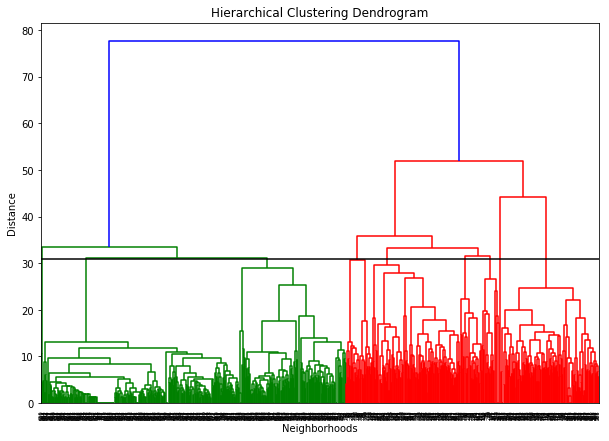

In [131]:
import scipy.cluster.hierarchy as shc

data = allvenues_grouped.iloc[:,6:]
plt.figure(figsize=(10, 7))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=31, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward')) 


## According to the above graph, I decide to separate our neighborhoods into nine clusters (cut at distance of 31, horizontal black line). I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods. 

In [133]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)  

In [134]:
allvenues_sorted['Cluster_Labels'] = clusterresult

In [165]:
# Define a function to show the neighborhoods with same cluster labels
def clustermap(cityname,countryname,dataframe):
    # create map
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Cluster_Labels
    colnum = 9
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map

    for lat, lon, neighborhood, borough, cluster_labels in zip(dataframe['Latitude'], 
                                                               dataframe['Longitude'], 
                                                               dataframe['NeighborhoodName'], 
                                                               dataframe['Borough'],
                                                               dataframe['Cluster_Labels']):
        cluster = cluster_labels 
        label = '{}, {},Cluster:{}'.format(neighborhood, borough,cluster_labels)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
       
    
    return my_map

## Total number of neighborhoods in each cluster


In [146]:
for ii in range(9):
    num = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == ii].shape[0]
    print('Total number of neighborhoods in cluster {} is {}'.format(ii, num))

Total number of neighborhoods in cluster 0 is 39
Total number of neighborhoods in cluster 1 is 159
Total number of neighborhoods in cluster 2 is 131
Total number of neighborhoods in cluster 3 is 32
Total number of neighborhoods in cluster 4 is 26
Total number of neighborhoods in cluster 5 is 3
Total number of neighborhoods in cluster 6 is 146
Total number of neighborhoods in cluster 7 is 2
Total number of neighborhoods in cluster 8 is 292


## Cluster 5 only has 3 neighborhoods and cluster 7 has only 2. These two clusters probably just contain the outliers. So let's look at cluster 5 and 7 first.

In [149]:
# cluster 5
allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 5]

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
560,Beijing,Dongcheng,Jingshan,39.9218,116.391,25,Historic Site,French Restaurant,Park,Scenic Lookout,History Museum,Garden,Bike Rental / Bike Share,Restaurant,Field,Filipino Restaurant,5
561,Beijing,Dongcheng,Donghuamen,39.9138,116.395,35,Historic Site,Park,French Restaurant,Beijing Restaurant,Pizza Place,Church,Electronics Store,Ice Cream Shop,Concert Hall,Toy / Game Store,5
650,Beijing,Xicheng,West Chang'an,39.9063,116.389,23,Historic Site,History Museum,Park,Scenic Lookout,Tea Room,Concert Hall,Castle,American Restaurant,Plaza,Monument / Landmark,5


In [150]:
# cluster 7
allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 7]

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
115,New York,Manhattan,Murray Hill,40.7483,-73.9783,79,Korean Restaurant,Sandwich Place,Pizza Place,Pub,Supermarket,Steakhouse,Speakeasy,Spa,Bakery,BBQ Joint,7
180,New York,Queens,Murray Hill,40.7641,-73.8128,79,Korean Restaurant,Sandwich Place,Pizza Place,Pub,Supermarket,Steakhouse,Speakeasy,Spa,Bakery,BBQ Joint,7


## Cluster 5 is the historical area of Beijing, thus no similar area is found in other cities. Cluster 7 is the same neighborhood throughout two boroughs, which is also unique in New York.

## Let's look at other neighborhood clusters.

## Cluster 0

In [166]:
cluster0 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 0]
cluster0

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,New York,Bronx,Wakefield,40.8947,-73.8472,41,Caribbean Restaurant,Pharmacy,Donut Shop,Supermarket,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Bakery,Cosmetics Shop,Burger Joint,0
8,New York,Bronx,Norwood,40.8772,-73.8794,46,Pizza Place,Fast Food Restaurant,Donut Shop,Pharmacy,Park,Mexican Restaurant,Mobile Phone Shop,Caribbean Restaurant,Supermarket,Bank,0
9,New York,Bronx,Williamsbridge,40.881,-73.8574,46,Pizza Place,Caribbean Restaurant,Fast Food Restaurant,Discount Store,Pharmacy,Supermarket,Deli / Bodega,Sandwich Place,Bakery,Fried Chicken Joint,0
14,New York,Bronx,University Heights,40.8557,-73.9104,47,Grocery Store,Pizza Place,Donut Shop,Shoe Store,Spanish Restaurant,Supermarket,Latin American Restaurant,Bank,African Restaurant,Sandwich Place,0
15,New York,Bronx,Morris Heights,40.8479,-73.9197,41,Pizza Place,Deli / Bodega,Pharmacy,Fast Food Restaurant,Grocery Store,Ice Cream Shop,Spanish Restaurant,Supermarket,Bank,Bridge,0
17,New York,Bronx,East Tremont,40.8427,-73.8874,47,Donut Shop,Pizza Place,Park,Bank,Zoo Exhibit,Sandwich Place,Lounge,Fast Food Restaurant,Shoe Store,Supermarket,0
18,New York,Bronx,West Farms,40.8395,-73.8777,42,Pizza Place,Donut Shop,Zoo,Park,Sandwich Place,Fast Food Restaurant,Lounge,Zoo Exhibit,Fried Chicken Joint,Paella Restaurant,0
23,New York,Bronx,Longwood,40.8151,-73.8958,48,Fast Food Restaurant,Sandwich Place,Discount Store,Donut Shop,Pharmacy,Grocery Store,Pizza Place,Latin American Restaurant,Mobile Phone Shop,Other Great Outdoors,0
25,New York,Bronx,Morrisania,40.8236,-73.9015,44,Discount Store,Fast Food Restaurant,Donut Shop,Pharmacy,Mobile Phone Shop,Pizza Place,Sandwich Place,Supermarket,Grocery Store,Diner,0
31,New York,Bronx,Westchester Square,40.8406,-73.8422,44,Pizza Place,Sandwich Place,Pharmacy,Fast Food Restaurant,Donut Shop,Restaurant,Supermarket,Diner,Latin American Restaurant,Bakery,0


## Cluster 0 contains the neighborhoods in New York with a lot of nearby pizza places, fast food restaurants and Caribbean restaurants.

In [214]:
clustermap('New York','USA',cluster0)

## Cluster 1

In [168]:
cluster1 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 1]
cluster1

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
19,New York,Bronx,High Bridge,40.8366,-73.9261,32,Baseball Field,Plaza,Park,Lounge,Sandwich Place,Smoke Shop,Seafood Restaurant,Gift Shop,Steakhouse,Track Stadium,1
24,New York,Bronx,Hunts Point,40.8097,-73.8833,22,Park,Seafood Restaurant,Bakery,Deli / Bodega,Pizza Place,Farmers Market,Bank,Pool,BBQ Joint,Travel & Transport,1
26,New York,Bronx,Soundview,40.821,-73.8657,45,Fast Food Restaurant,Supermarket,Deli / Bodega,Breakfast Spot,Department Store,Fried Chicken Joint,Park,Bus Statiion,Clothing Store,Kids Store,1
67,New York,Brooklyn,Red Hook,40.6763,-74.0128,38,Seafood Restaurant,Park,Flower Shop,Sandwich Place,Brewery,Ice Cream Shop,American Restaurant,Farm,Bagel Shop,BBQ Joint,1
127,New York,Manhattan,Battery Park City,40.7119,-74.0169,39,Park,Plaza,Fountain,BBQ Joint,Market,Dog Run,American Restaurant,Pizza Place,Memorial Site,Auditorium,1
152,New York,Queens,Auburndale,40.7617,-73.7918,43,Korean Restaurant,Cosmetics Shop,Greek Restaurant,Pharmacy,Ice Cream Shop,Japanese Restaurant,Diner,Pizza Place,Modern Greek Restaurant,Tapas Restaurant,1
166,New York,Queens,Rochdale,40.6752,-73.7726,25,Fast Food Restaurant,Sandwich Place,Pizza Place,Market,Deli / Bodega,Pub,Fried Chicken Joint,Candy Store,Caribbean Restaurant,Park,1
176,New York,Queens,Edgemere,40.5956,-73.7761,20,Pizza Place,Deli / Bodega,Park,Grocery Store,Seafood Restaurant,Gift Shop,Supermarket,Farm,Spa,Skate Park,1
183,New York,Queens,Jamaica Estates,40.7168,-73.7872,42,Fast Food Restaurant,Indian Restaurant,Deli / Bodega,Donut Shop,Convenience Store,Bank,Fried Chicken Joint,Pharmacy,Sandwich Place,Mobile Phone Shop,1
184,New York,Queens,Queensboro Hill,40.7446,-73.8258,31,Bakery,Asian Restaurant,Bank,Flower Shop,Park,Supermarket,Hobby Shop,Spa,Pizza Place,Historic Site,1


In [183]:
clustermap('New York','USA',cluster1[cluster1['City'] == 'New York'])

In [185]:
clustermap('Toronto','Canada',cluster1[cluster1['City'] == 'Toronto'])

In [186]:
clustermap('Shanghai','China',cluster1[cluster1['City'] == 'Shanghai'])

In [187]:
clustermap('Beijing','China',cluster1[cluster1['City'] == 'Beijing'])

## Cluster 1 is basically the residential area of each city. Each neighborhood has access to fast food restaurants and outdoor parks. There are also a lot of resaurants, convenience stores and supermarkets.

## cluster 2

In [188]:
cluster2 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 2]
cluster2

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
1,New York,Bronx,Co-op City,40.8743,-73.8299,44,Shoe Store,Mobile Phone Shop,Kids Store,Department Store,Discount Store,Bakery,Pharmacy,Mattress Store,Supermarket,Pizza Place,2
2,New York,Bronx,Eastchester,40.8876,-73.8278,41,Caribbean Restaurant,Diner,Fast Food Restaurant,Burger Joint,Women's Store,Supplement Shop,Donut Shop,Asian Restaurant,Discount Store,Grocery Store,2
3,New York,Bronx,Fieldston,40.8954,-73.9056,35,Pizza Place,Sandwich Place,Plaza,Mexican Restaurant,Burger Joint,Garden,Bakery,Bank,History Museum,Historic Site,2
7,New York,Bronx,Woodlawn,40.8983,-73.8673,44,Deli / Bodega,Pub,Discount Store,Italian Restaurant,Bakery,Pizza Place,Pharmacy,Rental Car Location,Donut Shop,American Restaurant,2
10,New York,Bronx,Baychester,40.8669,-73.8358,44,Department Store,Clothing Store,Discount Store,Pizza Place,Pharmacy,Shoe Store,Bagel Shop,Italian Restaurant,Supermarket,Steakhouse,2
22,New York,Bronx,Port Morris,40.8017,-73.9132,27,Pizza Place,Donut Shop,Grocery Store,Latin American Restaurant,Toll Plaza,Performing Arts Venue,Spanish Restaurant,Mobile Phone Shop,Gas Station,Tunnel,2
28,New York,Bronx,Throgs Neck,40.8151,-73.8164,29,Deli / Bodega,Italian Restaurant,Pizza Place,Trail,Park,Farmers Market,Fast Food Restaurant,Beach,Harbor / Marina,Home Service,2
35,New York,Bronx,Spuyten Duyvil,40.8814,-73.9172,41,Pizza Place,Park,Pharmacy,Bank,Thai Restaurant,Diner,Mexican Restaurant,Donut Shop,Toll Plaza,Bagel Shop,2
36,New York,Bronx,North Riverdale,40.9085,-73.9045,32,Pizza Place,Italian Restaurant,Pool,Japanese Restaurant,Diner,Burger Joint,Sandwich Place,Bagel Shop,Nature Preserve,Bank,2
39,New York,Bronx,Edgewater Park,40.822,-73.8139,38,Deli / Bodega,Italian Restaurant,Pizza Place,Donut Shop,Restaurant,Diner,Sandwich Place,Pub,Fast Food Restaurant,Asian Restaurant,2


In [189]:
clustermap('New York','USA',cluster2[cluster2['City'] == 'New York'])

In [191]:
clustermap('Toronto','Canada',cluster2[cluster2['City'] == 'Toronto'])

Cluster 2: New York and Toronto neighborhoods with pizza places, banks, mobile phone shops nearby.

## cluster 3

In [192]:
cluster3 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 3]
cluster3

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
11,New York,Bronx,Pelham Parkway,40.8574,-73.8548,42,Pizza Place,Donut Shop,Deli / Bodega,Sandwich Place,Italian Restaurant,Burger Joint,Bank,Bakery,Pharmacy,Supermarket,3
16,New York,Bronx,Fordham,40.861,-73.8964,42,Italian Restaurant,Pizza Place,Deli / Bodega,Diner,Video Game Store,Shoe Store,Plaza,Mobile Phone Shop,Supermarket,Vietnamese Restaurant,3
29,New York,Bronx,Country Club,40.8442,-73.8241,46,Italian Restaurant,Pizza Place,Sandwich Place,Bakery,Donut Shop,Bank,Deli / Bodega,Pharmacy,Dive Bar,BBQ Joint,3
32,New York,Bronx,Van Nest,40.8436,-73.8663,45,Pizza Place,Spanish Restaurant,Italian Restaurant,Supermarket,Donut Shop,Sandwich Place,Park,Zoo,Plaza,Pool Hall,3
33,New York,Bronx,Morris Park,40.8475,-73.8504,41,Pizza Place,Italian Restaurant,Sandwich Place,Burger Joint,Restaurant,Deli / Bodega,Supermarket,Pharmacy,Donut Shop,Latin American Restaurant,3
34,New York,Bronx,Belmont,40.8573,-73.8885,44,Italian Restaurant,Deli / Bodega,Bakery,Pizza Place,Dessert Shop,Diner,Park,Fast Food Restaurant,Mexican Restaurant,Cheese Shop,3
37,New York,Bronx,Pelham Bay,40.8506,-73.8321,43,Italian Restaurant,Sandwich Place,Pizza Place,Pharmacy,Bank,Convenience Store,Donut Shop,Bakery,Dive Bar,Rental Car Location,3
38,New York,Bronx,Schuylerville,40.8266,-73.8262,42,Pizza Place,Italian Restaurant,American Restaurant,Pharmacy,Donut Shop,Mexican Restaurant,Sandwich Place,Diner,Cosmetics Shop,Park,3
46,New York,Brooklyn,Bay Ridge,40.6258,-74.0306,44,Pizza Place,Spa,American Restaurant,Greek Restaurant,Grocery Store,Bakery,Cosmetics Shop,Department Store,Italian Restaurant,Optical Shop,3
47,New York,Brooklyn,Bensonhurst,40.611,-73.9952,40,Pizza Place,Bakery,Ice Cream Shop,Bagel Shop,Supplement Shop,Italian Restaurant,Liquor,Video Game Store,Bank,Vietnamese Restaurant,3


In [193]:
clustermap('New York','USA',cluster3[cluster3['City'] == 'New York'])

In [194]:
clustermap('Toronto','Canada',cluster3[cluster3['City'] == 'Toronto'])

## Cluster 3: Most are New York neighborhoods with a lot of Italian and pizza places.

In [195]:
## cluster 4
cluster4 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 4]
cluster4

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
4,New York,Bronx,Riverdale,40.8908,-73.9126,71,Bakery,Pizza Place,Park,Vietnamese Restaurant,Diner,Bagel Shop,Restaurant,Dog Run,Plaza,Playground,4
5,New York,Bronx,Kingsbridge,40.8817,-73.9028,40,Pizza Place,Mexican Restaurant,Spanish Restaurant,Diner,Burger Joint,Donut Shop,Bakery,Supermarket,Greek Restaurant,Gourmet Shop,4
6,New York,Manhattan,Marble Hill,40.8766,-73.9107,41,Mexican Restaurant,Pizza Place,Spanish Restaurant,Discount Store,Sandwich Place,Donut Shop,Supermarket,Thai Restaurant,Video Game Store,Gourmet Shop,4
13,New York,Bronx,Bedford Park,40.8702,-73.8855,83,Diner,Sandwich Place,Botanical Garden,Bakery,Pizza Place,Park,Supermarket,Pub,Japanese Restaurant,Garden,4
20,New York,Bronx,Melrose,40.8198,-73.9094,41,Mexican Restaurant,Pizza Place,Supermarket,Diner,Discount Store,Kids Store,Italian Restaurant,Pharmacy,Donut Shop,Video Game Store,4
21,New York,Bronx,Mott Haven,40.8062,-73.9161,42,Pizza Place,Donut Shop,Mexican Restaurant,Discount Store,Supermarket,Spanish Restaurant,Grocery Store,Steakhouse,Mobile Phone Shop,Clothing Store,4
30,New York,Bronx,Parkchester,40.8379,-73.856,44,Pizza Place,Spanish Restaurant,Latin American Restaurant,Diner,Caribbean Restaurant,Ice Cream Shop,Kids Store,Mexican Restaurant,Supermarket,Mobile Phone Shop,4
44,New York,Bronx,Unionport,40.8298,-73.8505,48,Pizza Place,Diner,Sandwich Place,Latin American Restaurant,Mobile Phone Shop,Ice Cream Shop,Supermarket,Spanish Restaurant,Mexican Restaurant,Donut Shop,4
48,New York,Brooklyn,Sunset Park,40.6451,-74.0103,42,Mexican Restaurant,Latin American Restaurant,Bakery,Pizza Place,Bank,Spanish Restaurant,Vietnamese Restaurant,Mobile Phone Shop,Grocery Store,Park,4
62,New York,Brooklyn,Bushwick,40.6981,-73.9253,31,Mexican Restaurant,Pizza Place,Latin American Restaurant,Thrift / Vintage Store,French Restaurant,Deli / Bodega,Sandwich Place,Pakistani Restaurant,Dive Bar,Grocery Store,4


In [196]:
clustermap('New York','USA',cluster4[cluster4['City'] == 'New York'])

In [197]:
clustermap('Toronto','Canada',cluster4[cluster4['City'] == 'Toronto'])

## Cluster 4 includes the neighborhoods in New York and Toronto. These neighborhoods have a lot of dining place with Mexican and American cuisine.

## cluster 6


In [198]:
## cluster 6
cluster6 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 6]
cluster6

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
12,New York,Bronx,City Island,40.8472,-73.7865,35,Harbor / Marina,Seafood Restaurant,Thrift / Vintage Store,Italian Restaurant,American Restaurant,Boat or Ferry,French Restaurant,Music Venue,Bank,Smoke Shop,6
49,New York,Brooklyn,Greenpoint,40.7302,-73.9542,34,Pizza Place,Yoga Studio,Mexican Restaurant,Record Shop,New American Restaurant,Gastropub,Vietnamese Restaurant,Vape Store,Grocery Store,Bookstore,6
52,New York,Brooklyn,Sheepshead Bay,40.5869,-73.9432,41,Turkish Restaurant,Japanese Restaurant,Pizza Place,Sandwich Place,Italian Restaurant,Restaurant,Burger Joint,Grocery Store,Bagel Shop,Dessert Shop,6
59,New York,Brooklyn,Prospect Heights,40.6768,-73.9649,33,New American Restaurant,Pizza Place,Southern / Soul Food Restaurant,Ice Cream Shop,American Restaurant,Bakery,Thai Restaurant,Vegetarian / Vegan Restaurant,Used Bookstore,Gourmet Shop,6
61,New York,Brooklyn,Williamsburg,40.7071,-73.9581,37,Pizza Place,Mediterranean Restaurant,Latin American Restaurant,Pilates Studio,Toy / Game Store,Breakfast Spot,Burger Joint,Taco Place,Steakhouse,South American Restaurant,6
64,New York,Brooklyn,Brooklyn Heights,40.6959,-73.9938,37,Park,Italian Restaurant,Yoga Studio,Burger Joint,Ice Cream Shop,American Restaurant,Pizza Place,Bakery,Men's Store,History Museum,6
65,New York,Brooklyn,Cobble Hill,40.6879,-73.9986,38,Bakery,Yoga Studio,Playground,Italian Restaurant,Pizza Place,Seafood Restaurant,Ice Cream Shop,Bagel Shop,Spa,Waterfront,6
66,New York,Brooklyn,Carroll Gardens,40.6805,-73.9947,33,Bakery,Italian Restaurant,Dessert Shop,Thai Restaurant,Pizza Place,Spa,Restaurant,Bookstore,Wings Joint,Playground,6
68,New York,Brooklyn,Gowanus,40.6739,-73.9944,34,Furniture / Home Store,Thai Restaurant,Italian Restaurant,Record Shop,Pizza Place,Brewery,Gourmet Shop,Yoga Studio,Bakery,Music Venue,6
69,New York,Brooklyn,Fort Greene,40.6885,-73.9729,41,Italian Restaurant,New American Restaurant,Pizza Place,American Restaurant,Opera House,Mexican Restaurant,Flower Shop,Latin American Restaurant,Caribbean Restaurant,Health & Beauty Service,6


In [199]:
clustermap('New York','USA',cluster6[cluster6['City'] == 'New York'])

In [201]:
clustermap('Toronto','Canada',cluster6[cluster6['City'] == 'Toronto'])

In [202]:
clustermap('Beijing','China',cluster6[cluster6['City'] == 'Beijing'])

In [203]:
clustermap('Shanghai','China',cluster6[cluster6['City'] == 'Shanghai'])

## Cluster 6 is basically the city center where surrounded by a variety of venues, including theaters, parks, restaurants and bars.

## cluster 8

In [204]:
## cluster 8
cluster8 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 8]
cluster8

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
27,New York,Bronx,Clason Point,40.8066,-73.8541,4,Park,Discount Store,Bus Statiion,Chinese Restaurant,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,8
76,New York,Brooklyn,Mill Island,40.6063,-73.9082,17,Burger Joint,Harbor / Marina,Pizza Place,Bowling Alley,Seafood Restaurant,Stables,Park,Boat or Ferry,Bakery,Golf Course,8
85,New York,Brooklyn,Sea Gate,40.5764,-74.0079,13,Beach,Pharmacy,Video Store,Supermarket,Park,Grocery Store,American Restaurant,Donut Shop,Spa,Gas Station,8
91,New York,Brooklyn,Bergen Beach,40.6151,-73.8986,11,Donut Shop,Italian Restaurant,Stables,Peruvian Restaurant,Supermarket,Athletics & Sports,Playground,Pizza Place,Deli / Bodega,Japanese Restaurant,8
171,New York,Queens,Broad Channel,40.603,-73.8201,9,Sandwich Place,Dive Bar,Other Nightlife,Surf Spot,Pizza Place,Playground,Bagel Shop,Beach,Deli / Bodega,Distillery,8
172,New York,Queens,Breezy Point,40.5574,-73.9255,6,Beach,Monument / Landmark,Lighthouse,American Restaurant,Trail,Surf Spot,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,8
192,New York,Queens,Somerville,40.5977,-73.7966,19,Donut Shop,Burger Joint,Taco Place,Caribbean Restaurant,Brewery,Supermarket,Grocery Store,Board Shop,Beach,Bank,8
203,New York,Staten Island,Todt Hill,40.5971,-74.1113,7,Campground,Bakery,Theater,Golf Course,Mountain,Park,Chinese Restaurant,Fountain,Fast Food Restaurant,Field,8
204,New York,Staten Island,South Beach,40.5802,-74.0796,8,Pier,Deli / Bodega,American Restaurant,Park,Playground,Athletics & Sports,Beach,Dive Bar,Farmers Market,Fast Food Restaurant,8
207,New York,Staten Island,Port Ivory,40.6397,-74.1746,6,Bus Statiion,Intersection,Snack Place,Boat or Ferry,Harbor / Marina,Chinese Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,8


In [211]:
clustermap('New York','USA',cluster8[cluster8['City'] == 'New York'])

In [207]:
clustermap('Toronto','Canada',cluster8[cluster8['City'] == 'Toronto'])

In [208]:
clustermap('Beijing','China',cluster8[cluster8['City'] == 'Beijing'])

In [209]:
clustermap('Shanghai','China',cluster8[cluster8['City'] == 'Shanghai'])

## Cluster 8 contains the neighborhoods without much nearby venues, including the suburb of New York, Toronto and most parts of Beijing and Shanghai. Please note that it doesn't mean Beijing and Shanghai are less bustling. In fact, Beijing and Shanghai have even larger density of population. I think this is because the venue information provider Foursquare is located in USA, thus New York and Toronto has much more information than Beijing and Shanghai. Some venue providers located in China may help to have a more detailed analysis.

## Anyhow, I hope I convince you that despite the distinct cultural and geographical location differences of New York, Toronto, Beijing and Shanghai, there are several similar neighborhoods in cluster 1, 2, 3, 4 and 6. I hope this could provide some useful information for peple who are considering moving among Canada, USA and China.

## Thank you for reading!